In [29]:
from QAOA_simulator import get_expectation, get_simulator, get_overlap, QAOA_run
import networkx as nx
import qokit.maxcut as mc
import numpy as np
import QAOA_proxy as qp
import QAOA_paper_proxy as qpp

# ノード数とQAOAの層数
N = 5
p = 1

# エルデシュ・レーニイグラフの生成（ノード数N、エッジの確率0.5）
G = nx.erdos_renyi_graph(N, 0.5)

# グラフからIsingモデルの項を取得
ising_model = mc.get_maxcut_terms(G)

# シミュレーターの初期化
sim = get_simulator(N, ising_model)

# 初期のgammaとbetaを設定（全て0.1）
init_gamma, init_beta = np.full((2, p), 0.1)

# QAOAプロキシを使ってQAOAの実行（結果としてgammaとbetaを取得）
result = qp.QAOA_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
gamma = result["gamma"]
beta = result["beta"]

# 得られたgammaとbetaで期待値を計算
expectation = get_expectation(N, ising_model, gamma, beta)

# シミュレーターからコスト対角成分の最大値を取得
max_cost_diagonal = max(sim.get_cost_diagonal())

# 近似比率（期待値/最大コスト対角成分）を計算
approx_ratio = expectation / max_cost_diagonal

# 近似比率を表示
print(f"approxmation raito (new proxy)= {approx_ratio}")


##############

# エルデシュ・レーニイグラフの生成（ノード数N、エッジの確率0.5）
G = nx.erdos_renyi_graph(N, 0.5)

# グラフからIsingモデルの項を取得
ising_model = mc.get_maxcut_terms(G)

# シミュレーターの初期化
sim = get_simulator(N, ising_model)

# 初期のgammaとbetaを設定（全て0.1）
init_gamma, init_beta = np.full((2, p), 0.1)

# QAOAプロキシを使ってQAOAの実行（結果としてgammaとbetaを取得）
result = qpp.QAOA_paper_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
gamma = result["gamma"]
beta = result["beta"]

# 得られたgammaとbetaで期待値を計算
expectation = get_expectation(N, ising_model, gamma, beta)

# シミュレーターからコスト対角成分の最大値を取得
max_cost_diagonal = max(sim.get_cost_diagonal())

# 近似比率（期待値/最大コスト対角成分）を計算
approx_ratio = expectation / max_cost_diagonal

# 近似比率を表示
print(f"approxmation raito (paper proxy)= {approx_ratio}")












approxmation raito (new proxy)= 0.5929699465179464
approxmation raito (paper proxy)= 0.8351529104961122


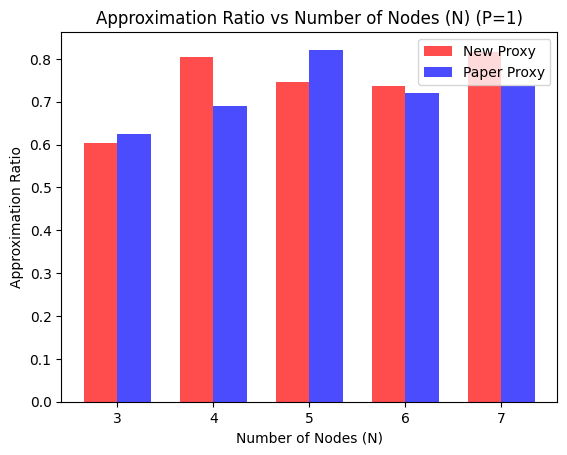

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import qokit.maxcut as mc
from QAOA_simulator import get_expectation, get_simulator
import QAOA_proxy as qp

# QAOAの層数
p = 1

# 結果を格納するリスト
approx_ratios_new_proxy = []
approx_ratios_paper_proxy = []

# Nを1から5まで変化させて計算
for N in range(3, 10):
    # エルデシュ・レーニイグラフの生成（ノード数N、エッジの確率0.5）
    G = nx.erdos_renyi_graph(N, 0.5)

    # グラフからIsingモデルの項を取得
    ising_model = mc.get_maxcut_terms(G)

    # シミュレーターの初期化
    sim = get_simulator(N, ising_model)

    # 初期のgammaとbetaを設定（全て0.1）
    init_gamma, init_beta = np.full((2, p), 0.1)

    # QAOAプロキシを使ってQAOAの実行（結果としてgammaとbetaを取得）
    result = qp.QAOA_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
    gamma = result["gamma"]
    beta = result["beta"]

    # 得られたgammaとbetaで期待値を計算
    expectation = get_expectation(N, ising_model, gamma, beta)

    # シミュレーターからコスト対角成分の最大値を取得
    max_cost_diagonal = max(sim.get_cost_diagonal())

    # 近似比率（期待値/最大コスト対角成分）を計算
    approx_ratio = expectation / max_cost_diagonal

    # 結果をリストに追加
    approx_ratios_new_proxy.append(approx_ratio)


for N in range(3, 10):
    # エルデシュ・レーニイグラフの生成（ノード数N、エッジの確率0.5）
    G = nx.erdos_renyi_graph(N, 0.5)

    # グラフからIsingモデルの項を取得
    ising_model = mc.get_maxcut_terms(G)

    # シミュレーターの初期化
    sim = get_simulator(N, ising_model)

    # 初期のgammaとbetaを設定（全て0.1）
    init_gamma, init_beta = np.full((2, p), 0.1)

    # QAOAプロキシを使ってQAOAの実行（結果としてgammaとbetaを取得）
    result = qpp.QAOA_paper_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
    gamma = result["gamma"]
    beta = result["beta"]

    # 得られたgammaとbetaで期待値を計算
    expectation = get_expectation(N, ising_model, gamma, beta)

    # シミュレーターからコスト対角成分の最大値を取得
    max_cost_diagonal = max(sim.get_cost_diagonal())

    # 近似比率（期待値/最大コスト対角成分）を計算
    approx_ratio = expectation / max_cost_diagonal
    
    # 結果をリストに追加
    approx_ratios_paper_proxy.append(approx_ratio)

# 棒グラフの作成
bar_width = 0.35  # バーの幅
index = np.arange(3, 10)  # x軸のインデックス

# 新しいプロキシの棒グラフ
plt.bar(index, approx_ratios_new_proxy, bar_width, color='red', alpha=0.7, label='New Proxy')

# 論文プロキシの棒グラフ
plt.bar(index + bar_width, approx_ratios_paper_proxy, bar_width, color='blue', alpha=0.7, label='Paper Proxy')

# グラフの設定
plt.xlabel('Number of Nodes (N)')
plt.ylabel('Approximation Ratio')
plt.title(f'Approximation Ratio vs Number of Nodes (N) (P={p})')
plt.xticks(index + bar_width / 2, index)  # x軸の目盛りを設定
plt.legend()

# グラフの表示
plt.show()



In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import qokit.maxcut as mc
from QAOA_simulator import get_expectation, get_simulator
import QAOA_proxy as qp
import QAOA_paper_proxy as qpp

# QAOAの層数
p = 1

# 各Nの近似比率を格納するリスト（各Nに対して10回の平均を格納）
approx_ratios_new_proxy = []
approx_ratios_paper_proxy = []

# Nを5から10まで変化させて計算
for N in range(3, 10):
    # 各Nについて10回の試行の近似比率を格納するリスト
    approx_ratios_new_proxy_i = []

    for _ in range(10):
        # エルデシュ・レーニイグラフの生成（ノード数N、エッジの確率0.5）
        G = nx.erdos_renyi_graph(N, 0.5)

        # グラフからIsingモデルの項を取得
        ising_model = mc.get_maxcut_terms(G)

        # シミュレーターの初期化
        sim = get_simulator(N, ising_model)

        # 初期のgammaとbetaを設定（全て0.1）
        init_gamma, init_beta = np.full((2, p), 0.1)

        # QAOAプロキシを使ってQAOAの実行（結果としてgammaとbetaを取得）
        result = qp.QAOA_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
        gamma = result["gamma"]
        beta = result["beta"]

        # 得られたgammaとbetaで期待値を計算
        expectation = get_expectation(N, ising_model, gamma, beta)

        # シミュレーターからコスト対角成分の最大値を取得
        max_cost_diagonal = max(sim.get_cost_diagonal())

        # 近似比率（期待値/最大コスト対角成分）を計算
        approx_ratio = expectation / max_cost_diagonal

        # 結果をリストに追加
        approx_ratios_new_proxy_i.append(approx_ratio)

        # 各Nに対して10回の試行の平均を計算
    approx_ratios_new_proxy.append(np.mean(approx_ratios_new_proxy_i))



for N in range(3, 10):
    # 各Nについて10回の試行の近似比率を格納するリスト
    approx_ratios_paper_proxy_i = []

    for _ in range(10):       
    # QAOAプロキシ（論文版）を使ってQAOAの実行（結果としてgammaとbetaを取得）
        result = qpp.QAOA_paper_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
        gamma = result["gamma"]
        beta = result["beta"]

        # 得られたgammaとbetaで期待値を計算
        expectation = get_expectation(N, ising_model, gamma, beta)

        # シミュレーターからコスト対角成分の最大値を取得
        max_cost_diagonal = max(sim.get_cost_diagonal())

        # 近似比率（期待値/最大コスト対角成分）を計算
        approx_ratio = expectation / max_cost_diagonal

        # 結果をリストに追加
        approx_ratios_paper_proxy_i.append(approx_ratio)

    # 各Nに対して10回の試行の平均を計算
    approx_ratios_paper_proxy.append(np.mean(approx_ratios_paper_proxy_i))

# 棒グラフの作成
bar_width = 0.35  # バーの幅
index = np.arange(3, 10)  # x軸のインデックス

# 新しいプロキシの棒グラフ
plt.bar(index - bar_width / 2, approx_ratios_new_proxy, bar_width, color='red', alpha=0.7, label='New Proxy')

# 論文プロキシの棒グラフ
plt.bar(index + bar_width / 2, approx_ratios_paper_proxy, bar_width, color='blue', alpha=0.7, label='Paper Proxy')

# グラフの設定
plt.xlabel('Number of Nodes (N)')
plt.ylabel('Approximation Ratio')
plt.title(f'Approximation Ratio vs Number of Nodes (N) (P={p})')
plt.xticks(index)  # x軸の目盛りを設定
plt.legend()

# グラフの表示
plt.show()


/tmp/ipykernel_171625/1384551814.py:46: RuntimeWarning: invalid value encountered in double_scalars
  approx_ratio = expectation / max_cost_diagonal


In [37]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import qokit.maxcut as mc
from QAOA_simulator import get_expectation, get_simulator
import QAOA_proxy as qp

# QAOAの層数
p = 5

# 結果を格納するリスト
approx_ratios_new_proxy = []
approx_ratios_paper_proxy = []

# Nを1から5まで変化させて計算
for N in range(3, 10):
    # エルデシュ・レーニイグラフの生成（ノード数N、エッジの確率0.5）
    G = nx.erdos_renyi_graph(N, 0.5)

    # グラフからIsingモデルの項を取得
    ising_model = mc.get_maxcut_terms(G)

    # シミュレーターの初期化
    sim = get_simulator(N, ising_model)

    # 初期のgammaとbetaを設定（全て0.1）
    init_gamma, init_beta = np.full((2, p), 0.1)

    # QAOAプロキシを使ってQAOAの実行（結果としてgammaとbetaを取得）
    result = qp.QAOA_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
    gamma = result["gamma"]
    beta = result["beta"]

    # 得られたgammaとbetaで期待値を計算
    expectation = get_expectation(N, ising_model, gamma, beta)

    # シミュレーターからコスト対角成分の最大値を取得
    max_cost_diagonal = max(sim.get_cost_diagonal())

    # 近似比率（期待値/最大コスト対角成分）を計算
    approx_ratio = expectation / max_cost_diagonal

    # 結果をリストに追加
    approx_ratios_new_proxy.append(approx_ratio)


for N in range(3, 10):
    # エルデシュ・レーニイグラフの生成（ノード数N、エッジの確率0.5）
    G = nx.erdos_renyi_graph(N, 0.5)

    # グラフからIsingモデルの項を取得
    ising_model = mc.get_maxcut_terms(G)

    # シミュレーターの初期化
    sim = get_simulator(N, ising_model)

    # 初期のgammaとbetaを設定（全て0.1）
    init_gamma, init_beta = np.full((2, p), 0.1)

    # QAOAプロキシを使ってQAOAの実行（結果としてgammaとbetaを取得）
    result = qpp.QAOA_paper_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
    gamma = result["gamma"]
    beta = result["beta"]

    # 得られたgammaとbetaで期待値を計算
    expectation = get_expectation(N, ising_model, gamma, beta)

    # シミュレーターからコスト対角成分の最大値を取得
    max_cost_diagonal = max(sim.get_cost_diagonal())

    # 近似比率（期待値/最大コスト対角成分）を計算
    approx_ratio = expectation / max_cost_diagonal
    
    # 結果をリストに追加
    approx_ratios_paper_proxy.append(approx_ratio)

# 棒グラフの作成
bar_width = 0.35  # バーの幅
index = np.arange(3, 10)  # x軸のインデックス

# 新しいプロキシの棒グラフ
plt.bar(index, approx_ratios_new_proxy, bar_width, color='red', alpha=0.7, label='New Proxy')

# 論文プロキシの棒グラフ
plt.bar(index + bar_width, approx_ratios_paper_proxy, bar_width, color='blue', alpha=0.7, label='Paper Proxy')

# グラフの設定
plt.xlabel('Number of Nodes (N)')
plt.ylabel('Approximation Ratio')
plt.title(f'Approximation Ratio vs Number of Nodes (N) (P={p})')
plt.xticks(index + bar_width / 2, index)  # x軸の目盛りを設定
plt.legend()

# グラフの表示
plt.show()

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 